In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
%matplotlib inline

In [3]:
df1 = pd.read_csv('train_image_level.csv')
df1['StudyInstanceUID'] = df1['StudyInstanceUID'].str.rstrip(' ')
df1.StudyInstanceUID = df1.StudyInstanceUID.astype(str)

In [4]:
df2 = pd.read_csv('train_study_level.csv')
df2['id'] = df2['id'].str.rstrip('_study ')
df2['id'] = df2['id'].str.rstrip('_study')
df2['id'] = df2['id'].str.rstrip(' ')
df2.id = df2.id.astype(str)

In [5]:
df1.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6334 entries, 0 to 6333
Data columns (total 4 columns):
id                  6334 non-null object
boxes               4294 non-null object
label               6334 non-null object
StudyInstanceUID    6334 non-null object
dtypes: object(4)
memory usage: 198.1+ KB


In [7]:
df2.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852,0,1,0,0
1,000c9c05fd14,0,0,0,1
2,00292f8c37b,1,0,0,0
3,005057b3f880,1,0,0,0
4,0051d9b12e72,0,0,0,1


In [8]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6054 entries, 0 to 6053
Data columns (total 5 columns):
id                          6054 non-null object
Negative for Pneumonia      6054 non-null int64
Typical Appearance          6054 non-null int64
Indeterminate Appearance    6054 non-null int64
Atypical Appearance         6054 non-null int64
dtypes: int64(4), object(1)
memory usage: 236.6+ KB


In [9]:
df = pd.merge(df1, df2, left_on='StudyInstanceUID', right_on='id', how='outer')

In [10]:
df.head()

,id_x,boxes,label,StudyInstanceUID,id_y,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,5776db0cec75,0.0,1.0,0.0,0.0
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,NaN,NaN,NaN,NaN,NaN
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,9d514ce429a7,0.0,1.0,0.0,0.0
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,28dddc8559b2,0.0,0.0,0.0,1.0
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,dfd9fdd85a3e,0.0,1.0,0.0,0.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6708 entries, 0 to 6707
Data columns (total 9 columns):
id_x                        6334 non-null object
boxes                       4294 non-null object
label                       6334 non-null object
StudyInstanceUID            6334 non-null object
id_y                        6310 non-null object
Negative for Pneumonia      6310 non-null float64
Typical Appearance          6310 non-null float64
Indeterminate Appearance    6310 non-null float64
Atypical Appearance         6310 non-null float64
dtypes: float64(4), object(5)
memory usage: 524.1+ KB


In [12]:
df.describe()

,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
count,6310.000000,6310.000000,6310.000000,6310.000000
mean,0.274326,0.474168,0.175119,0.076387
std,0.446210,0.499372,0.380099,0.265637
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


In [13]:
colNegPneu = df['Negative for Pneumonia'].value_counts()
colTypApp = df['Typical Appearance'].value_counts()
colIntApp = df['Indeterminate Appearance'].value_counts()
colAtyApp = df['Atypical Appearance'].value_counts()

In [14]:
listColumns = [colNegPneu, colTypApp, colIntApp, colAtyApp]
listColumnsNames = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
for i in range(len(listColumnsNames)):
    a = (100*listColumns[i][0])/sum(listColumns[i])
    print("La proporcion de 0's en ", listColumnsNames[i], "es: \t", a)
    b = (100*listColumns[i][1])/sum(listColumns[i])
    print("La proporcion de 1's en ", listColumnsNames[i], "es: \t", b)

La proporcion de 0's en  Negative for Pneumonia es: 	 72.56735340729001
La proporcion de 1's en  Negative for Pneumonia es: 	 27.432646592709983
La proporcion de 0's en  Typical Appearance es: 	 52.58320126782884
La proporcion de 1's en  Typical Appearance es: 	 47.41679873217116
La proporcion de 0's en  Indeterminate Appearance es: 	 82.48811410459588
La proporcion de 1's en  Indeterminate Appearance es: 	 17.51188589540412
La proporcion de 0's en  Atypical Appearance es: 	 92.36133122028527
La proporcion de 1's en  Atypical Appearance es: 	 7.638668779714738


([Text(0, 0, '4579'), Text(0, 0, '1731')],)

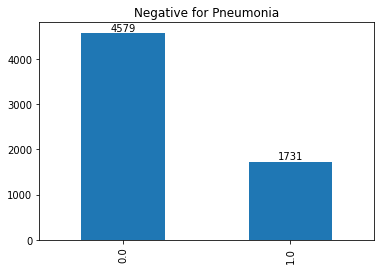

In [15]:
ax = colNegPneu.plot.bar()
ax.set_title(listColumnsNames[0])
ax.bar_label(ax.containers[0]),

[Text(0, 0, '3318'), Text(0, 0, '2992')]

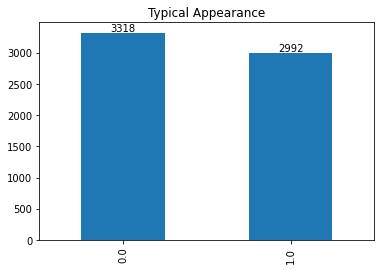

In [16]:
ax = colTypApp.plot.bar()
ax.set_title(listColumnsNames[1])
ax.bar_label(ax.containers[0])

[Text(0, 0, '5205'), Text(0, 0, '1105')]

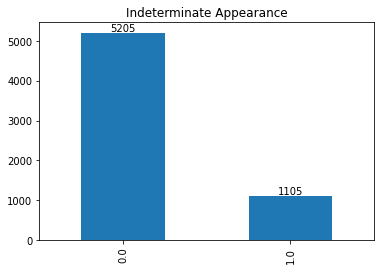

In [17]:
ax = colIntApp.plot.bar()
ax.set_title(listColumnsNames[2])
ax.bar_label(ax.containers[0])

[Text(0, 0, '5828'), Text(0, 0, '482')]

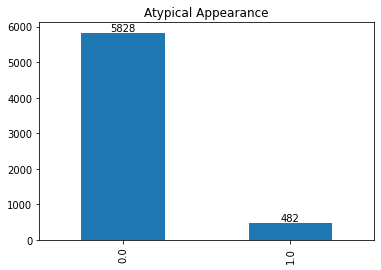

In [18]:
ax = colAtyApp.plot.bar()
ax.set_title(listColumnsNames[3])
ax.bar_label(ax.containers[0])

In [19]:
df1.loc[df1['label'] == 'none 1 0 0 1 1']

,id,boxes,label,StudyInstanceUID
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
6,0023f02ae886_image,NaN,none 1 0 0 1 1,2fa400b873f5
22,00c1515729a8_image,NaN,none 1 0 0 1 1,1a58b43cf286
24,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb
26,010214f9b600_image,NaN,none 1 0 0 1 1,2a7b4e669dda
...,...,...,...,...
6322,ff7659762b75_image,NaN,none 1 0 0 1 1,4aa11ef1fd38
6324,ff9f10a24c27_image,NaN,none 1 0 0 1 1,a937614104e3
6325,ffa9fef3c7bf_image,NaN,none 1 0 0 1 1,5133bbb7b75c
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06


In [20]:
dfLabel = df.loc[df['label'] == 'none 1 0 0 1 1']

In [21]:
dfLabel

,id_x,boxes,label,StudyInstanceUID,id_y,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,NaN,NaN,NaN,NaN,NaN
6,0023f02ae886_image,NaN,none 1 0 0 1 1,2fa400b873f5,2fa400b873f5,1.0,0.0,0.0,0.0
22,00c1515729a8_image,NaN,none 1 0 0 1 1,1a58b43cf286,1a58b43cf286,0.0,1.0,0.0,0.0
25,00e3a7e91a34_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1.0,0.0,0.0,0.0
26,0d4d6acc9ed3_image,NaN,none 1 0 0 1 1,74ba8f2badcb,74ba8f2badcb,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
6322,ff7659762b75_image,NaN,none 1 0 0 1 1,4aa11ef1fd38,4aa11ef1fd38,1.0,0.0,0.0,0.0
6324,ff9f10a24c27_image,NaN,none 1 0 0 1 1,a937614104e3,a937614104e3,1.0,0.0,0.0,0.0
6325,ffa9fef3c7bf_image,NaN,none 1 0 0 1 1,5133bbb7b75c,5133bbb7b75c,1.0,0.0,0.0,0.0
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,7e6c68462e06,1.0,0.0,0.0,0.0


In [22]:
colNegPneuLabel = dfLabel['Negative for Pneumonia'].value_counts()
colTypAppLabel = dfLabel['Typical Appearance'].value_counts()
colIntAppLabel = dfLabel['Indeterminate Appearance'].value_counts()
colAtyAppLabel = dfLabel['Atypical Appearance'].value_counts()

In [23]:
listColumns = [colNegPneuLabel, colTypAppLabel, colIntAppLabel, colAtyAppLabel]
listColumnsNames = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
for i in range(len(listColumnsNames)):
    a = (100*listColumns[i][0])/sum(listColumns[i])
    print("La proporcion de 0's en ", listColumnsNames[i], "es: \t", a)
    b = (100*listColumns[i][1])/sum(listColumns[i])
    print("La proporcion de 1's en ", listColumnsNames[i], "es: \t", b)

La proporcion de 0's en  Negative for Pneumonia es: 	 14.976353126642143
La proporcion de 1's en  Negative for Pneumonia es: 	 85.02364687335786
La proporcion de 0's en  Typical Appearance es: 	 92.74829217025749
La proporcion de 1's en  Typical Appearance es: 	 7.251707829742512
La proporcion de 0's en  Indeterminate Appearance es: 	 97.05727798213347
La proporcion de 1's en  Indeterminate Appearance es: 	 2.9427220178665263
La proporcion de 0's en  Atypical Appearance es: 	 95.21807672096689
La proporcion de 1's en  Atypical Appearance es: 	 4.781923279033106


[Text(0, 0, '1618'), Text(0, 0, '285')]

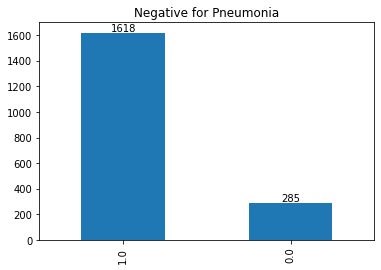

In [24]:
ax = colNegPneuLabel.plot.bar()
ax.set_title(listColumnsNames[0])
ax.bar_label(ax.containers[0])

[Text(0, 0, '1765'), Text(0, 0, '138')]

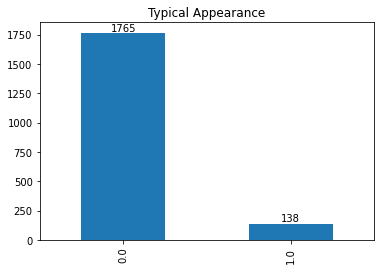

In [25]:
ax = colTypAppLabel.plot.bar()
ax.set_title(listColumnsNames[1])
ax.bar_label(ax.containers[0])

[Text(0, 0, '1847'), Text(0, 0, '56')]

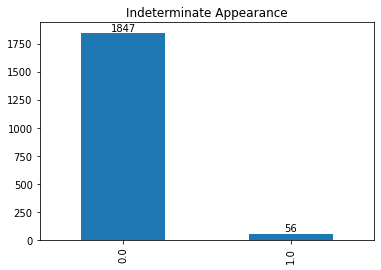

In [26]:
ax = colIntAppLabel.plot.bar()
ax.set_title(listColumnsNames[2])
ax.bar_label(ax.containers[0])

[Text(0, 0, '1812'), Text(0, 0, '91')]

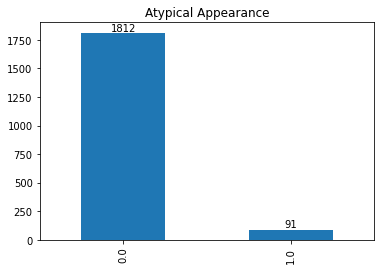

In [27]:
ax = colAtyAppLabel.plot.bar()
ax.set_title(listColumnsNames[3])
ax.bar_label(ax.containers[0])